In [1]:
import sys, os
import pandas as pd
import numpy as np
import json
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from glob import glob
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None

## Matplotlib Setting

In [2]:
%run "../scripts/helper_functions.py"

In [3]:
data_path = os.path.abspath("../../data/Data_11_9/")
vcas = ["meet", "teams"]
ip = '192.168.1.187'

## Conversion PCAP to CSV

In [ ]:
force = True
dirlist = os.listdir(data_path)
for dirname in dirlist: 
    for vca in vcas:
        path_name = f"{data_path}/{dirname}/{vca}/captures/*.pcap"
        files = glob(path_name)
        if len(files) == 0:
            continue
        filename = files[0]
        outfile = filename[:filename.rfind(".")] + ".csv"
        if os.path.exists(outfile) and force == False:
            continue
        print(filename)
        pcap_to_csv(filename, outfile)
        #%run "../scripts/pcap2csv-scapy.py" {data_path} {vca}

## Read Data

In [7]:
net_cols= ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker','rtp.padding','rtp.ext','rtp.ext.len','rtcp.pt','rtcp.senderssrc','rtcp.ssrc.high_seq','rtcp.ssrc.dlsr','rtcp.psfb.fmt', 'rtcp.rtpfb.fmt','rtcp.sender.octetcount']
data = {}
for vca in vcas:
    data[vca] = {}

In [8]:
def is_valid_trace(df_webrtc, df_net):
    webrtc_ts_st = df_webrtc['ts'].min()
    webrtc_ts_et = df_webrtc['ts'].max()

    net_ts_st = df_net['frame.time_epoch'].min()
    net_ts_et = df_net['frame.time_epoch'].max()

    if webrtc_ts_st < net_ts_et and webrtc_ts_st > net_ts_st:
        return True

    if net_ts_st < webrtc_ts_et and net_ts_st > webrtc_ts_st:
        return True
    
    return False

In [9]:
dirlist = os.listdir(data_path)
for dirname in dirlist:
    for vca in vcas:
        webrtc_files = glob(f"{data_path}/{dirname}/{vca}/webrtc/*.json")
        net_files = glob(f"{data_path}/{dirname}/{vca}/captures/*.csv")
        
        if len(webrtc_files) == 0 or len(net_files) == 0:
            continue
        webrtc_filename, net_filename = (webrtc_files[0], net_files[0])
        pref = os.path.basename(webrtc_filename)
        
        try:
            df_webrtc = get_webrtc(webrtc_filename)
            df_webrtc = df_webrtc.dropna(subset=["framesPerSecond"])
            if df_webrtc.empty:
                continue
            df_webrtc['fname'] = pref
        except ValueError:
            print("webrtc reading error", webrtc_filename)
            continue

        df_net = pd.read_csv(net_filename, header=None, sep='\t', names=net_cols, lineterminator='\n', encoding='ascii')
        ## Filter incoming RTP traffic only
        df_net = df_net[(df_net["ip.dst"] == ip) & ~(pd.isna(df_net["rtp.p_type"]))]
        df_net['fname'] = pref

        

        if not is_valid_trace(df_webrtc, df_net):
            print("invalid trce", net_filename, webrtc_filename)
            continue
        
        file_map = {"webrtc": df_webrtc, "pcap": df_net}
        data[vca][pref] = file_map
        

invalid trce /Users/tarun/Desktop/Projects/vca-qoe-inference/data/Data_11_9/2022-11-07_teams_6_0_0_0_0_0_1667868998/teams/captures/teams-chrome-6-0-0-0-0-0-1667868998-1667869029.csv /Users/tarun/Desktop/Projects/vca-qoe-inference/data/Data_11_9/2022-11-07_teams_6_0_0_0_0_0_1667868998/teams/webrtc/chrome-6-0-0-0-0-0-1667868998-1667869069.json


In [10]:
def get_data_vca(data, vca, data_type):
    return pd.concat([data[vca][x][data_type] for x in data[vca]]).reset_index()

df_webrtc_teams = get_data_vca(data, "teams", "webrtc")
df_webrtc_meet = get_data_vca(data, "meet", "webrtc")
df_net_teams = get_data_vca(data, "teams", "pcap")
df_net_meet = get_data_vca(data, "meet", "pcap")
df_webrtc_teams['vca'] = "teams"
df_net_teams['vca'] = "teams"
df_webrtc_meet['vca'] = "meet"
df_net_meet['vca'] = "meet"
df_webrtc_all = pd.concat([df_webrtc_meet, df_webrtc_teams]).reset_index()
df_net_all = pd.concat([df_net_meet, df_net_teams]).reset_index()

In [127]:
df_net_all.to_csv("../../data/net_all.csv")
df_webrtc_all.to_csv("../../data/webrtc_all.csv")

## Frames Per Second vs Received Frames Per Second

In [4]:
(col1, col2) = ("framesPerSecond", "framesReceived")
diff_col = f"Diff ({col1}, {col2})"
norm_diff_col = f"Norm. Diff ({col1}, {col2})"
df_webrtc_all[diff_col] = df_webrtc_all[col1] - df_webrtc_all[col2]
sns.ecdfplot(data=df_webrtc_all, x="diff", hue="vca")
plt.xlim([-10, 10])
plt.grid()
t = plt.yticks([0.1*x for x in range(10)])
df_grp = df_webrtc_all.groupby(['vca', 'fname']).agg({diff_col: "sum", "framesReceived": "sum"}).reset_index()
df_grp[norm_diff_col] = df_grp[diff_col] / df_grp[col2]
plt.figure()
sns.ecdfplot(data=df_grp, x=diff_col, hue="vca")
plt.grid()
plt.figure()
sns.ecdfplot(data=df_grp, x=norm_diff_col, hue="vca")
plt.grid()

NameError: name 'df_webrtc_all' is not defined

In [23]:
print(df_grp[df_grp[diff_col] > 0]['vca'].value_counts())
print(df_grp['vca'].value_counts())

teams    205
meet     155
Name: vca, dtype: int64
meet     230
teams    229
Name: vca, dtype: int64


In [ ]:
pd.options.display.max_rows = 200
webrtc_filename = ""
net_filename = "/data/vca-qoe-inference/data/Data_11_9/2022-11-07_teams_5_0_50_0_0_0_1667877199/teams/captures/teams-chrome-5-0-50-0-0-0-1667877199-1667877230.csv"
df_net = pd.read_csv(net_filename, header=None, sep='\t', names=net_cols, lineterminator='\n', encoding='ascii')
df_net[(df_net["ip.dst"] == ip) & (df_net["ip.proto"] == 17)].head(200)

## QoE visualization

### Network vs QoE plots

In [ ]:
def get_field(x, pos):
    str_arr = x.split('-')
    return float(str_arr[pos])
vcas = ['meet']
network_stat_pos = {'loss': 5, 'latency': 3, 'latency_jitter': 4, 'tput': 1, 'tput_var': 2} 
for network_stat_name in network_stat_pos:
    for vca in vcas:
        df = pd.concat([data[vca][x]['webrtc'] for x in data[vca]]).reset_index()
        df[network_stat_name] = df['fname'].apply(lambda x: get_field(x, network_stat_pos[network_stat_name]))
        sns.lineplot(data=df, x=network_stat_name, y="framesPerSecond")
        plt.figure()

### RTP vs RTCP difference

<AxesSubplot:xlabel='udp.length', ylabel='Proportion'>

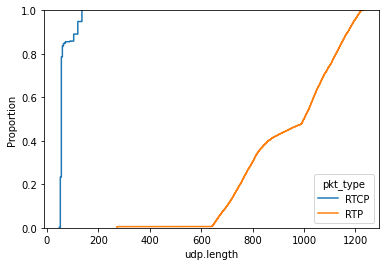

In [63]:
def get_type(x):
    if not pd.isna(x["rtp.p_type"]):
        return "RTP"
    elif not pd.isna(x["rtcp.pt"]):
        return "RTCP"
    else:
        return None
vca = "meet"
df_net = pd.concat([data[vca][x]["pcap"] for x in data[vca]]).reset_index()
df_net[(df_net["ip.dst"] == ip) & (df_net["ip.proto"] == 17) & (df_net["ip.src"] == "142.250.82.185")]
df_net["pkt_type"] = df_net.apply(get_type, axis=1)
sns.ecdfplot(data=df_net, x="udp.length", hue="pkt_type")

## Media Identification

## Defining params

### Functions for media classification

In [37]:
video_size_thresh = {'meet': 300, 'teams': 400}

video_ptypes = {'meet': [98, 99], 'teams': [102, 123]}

def get_p_type(p_type, vca):
    if isinstance(p_type, str) and ',' in p_type:
        p_type = p_type.split(',')[0]
    p_type = int(p_type)
    return p_type
    

def is_video_rtp(p_type, vca):
    p_type = get_p_type(p_type, vca)
    if p_type in video_ptypes[vca]:
        return 1
    else:
        return 0

def is_video_udp(x, vca):
    if int(x) > video_size_thresh[vca]:
        return 1
    else:
        return 0

<AxesSubplot:xlabel='udp.length', ylabel='Proportion'>

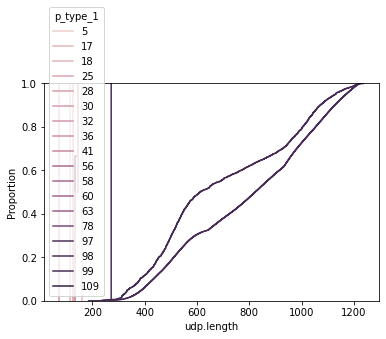

In [57]:
df_net["p_type_1"] = df_net["rtp.p_type"].apply(lambda x: get_p_type(x, vca))
sns.ecdfplot(data=df_net, x="udp.length", hue="p_type_1")

### Classification and printing confusion matrix

In [54]:
vca = "meet"
df_net = pd.concat([data[vca][x]["pcap"] for x in data[vca]]).reset_index()
df_net["is_video_rtp"] = df_net["rtp.p_type"].apply(lambda x: is_video_rtp(x, vca))
df_net["is_video_udp"] = df_net["udp.length"].apply(lambda x: is_video_udp(x, vca))

confusion_matrix(df_net["is_video_rtp"], df_net["is_video_udp"], normalize='true')

array([[1.        , 0.        ],
       [0.00485294, 0.99514706]])

## Intra vs inter size difference

In [209]:
def get_diff(l):
    diff = 0
    for i in range(1, len(l)):
        cur_diff = abs(l[i] - l[i-1])
        if cur_diff > diff:
            diff = cur_diff
    return diff

def get_intra_inter(df_net):
    df_net['frame.time_relative'] = df_net['frame.time_relative'].astype(float)
    df_net["is_video_rtp"] = df_net["rtp.p_type"].apply(lambda x: is_video_rtp(x, vca))
    df_video = df_net[df_net['is_video_rtp'] == 1]
    df_grp = df_video.groupby("rtp.timestamp").agg({"udp.length": list, "rtp.p_type": list, "frame.time_relative": list}).reset_index()

    # df_grp['diff'] = df_grp.apply(lambda x: get_rtx_vid_diff(x, vca), axis=1)
    df_grp["intra"] = 0
    df_grp["inter"] = 0
    df_grp["intra_rel"] = 0
    df_grp["inter_rel"] = 0
    for i in range(1, df_grp.shape[0]):
        size_list = df_grp.iloc[i]["udp.length"]
        time_list = df_grp.iloc[i]['frame.time_relative']
        size_list_prev = df_grp.iloc[i-1]["udp.length"]
        df_grp.at[i, 'intra'] = get_diff(size_list)
        df_grp.at[i, 'inter'] = abs(size_list_prev[-1] - size_list[0])
        df_grp.at[i, 'intra_rel'] = get_diff(size_list) / min(size_list)
        df_grp.at[i, 'inter_rel'] = abs(size_list_prev[-1] - size_list[0]) / size_list_prev[-1]
        df_grp.at[i, 'intra_time_diff'] = get_diff(time_list)
    df_grp['intra_sdev'] = df_grp['intra'].std()
    df_grp['inter_sdev'] = df_grp['inter'].std()
    return df_grp


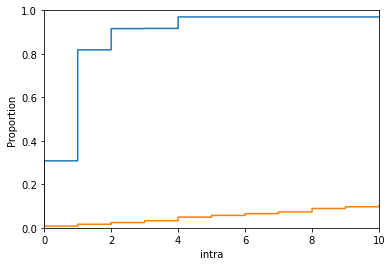

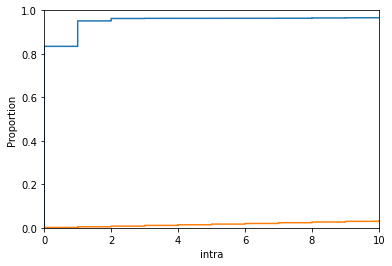

In [215]:
vca = "teams"
for vca in vcas:
    df_net = pd.concat([data[vca][x]['pcap'] for x in data[vca]]).reset_index()
    df_grp = get_intra_inter(df_net)
    plt.figure()
    sns.ecdfplot(x=df_grp["intra"])
    sns.ecdfplot(x=df_grp["inter"])
    plt.xlim([0,10])

(0.0, 10.0)

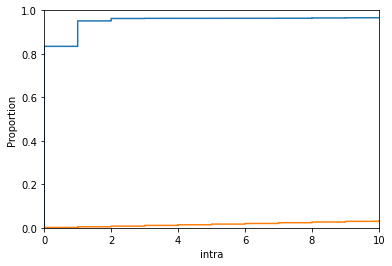

In [207]:
df_grp = df_net.groupby("rtp.timestamp").agg({"udp.length": list, "rtp.p_type": list, "frame.time_relative": list}).reset_index()
df_grp["n_pkts"] = df_grp['udp.length'].apply(len)
df_grp["frame_size"] = df_grp['udp.length'].apply(sum)
df_grp['pkt_size'] = df_grp['udp.length'].apply(np.mean)

In [62]:
df_grp1 = df_grp[df_grp['pkt_size'] > 300]

(0.0, 1000.0)

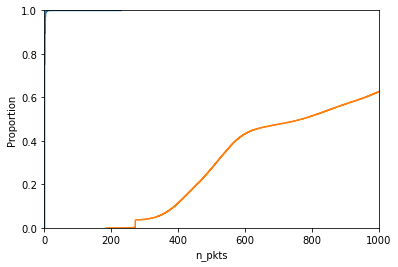

In [66]:
sns.ecdfplot(df_grp['n_pkts'])
sns.ecdfplot(df_grp['frame_size'])
plt.xlim([0, 1000])

## Frame mis-classification probability

1    230788
0      6371
Name: is_video_rtp, dtype: int64

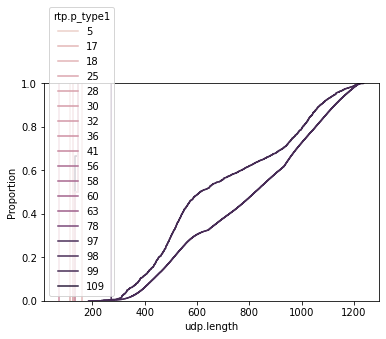

In [67]:
df_net["rtp.p_type1"] = df_net["rtp.p_type"].apply(lambda x: get_p_type(x, vca))

sns.ecdfplot(data=df_net, x="udp.length", hue="rtp.p_type1")
df_net["is_video_rtp"].value_counts()

## Frame boundary identification

In [70]:
vca_list = ["teams", "meet"]
stat = []
for vca in vca_list:
    df_net = pd.concat([data[vca][x]['pcap'] for x in data[vca]]).reset_index()
    df_net["is_video_rtp"] = df_net["rtp.p_type"].apply(lambda x: is_video_rtp(x, vca))
    df_grp = df_net.groupby(["rtp.timestamp", "fname", "is_video_rtp"]).agg({"udp.length": np.mean, "rtp.p_type": "count"}).reset_index()

    SIZE_IDX = 3
    for skip in range(1,11):
        total, mis_classification = (0, 0)
        for fname in df_grp["fname"].unique().tolist():
            df1 = df_grp[(df_grp["fname"] == fname) & (df_grp["is_video_rtp"] == 1)]
            df1 = df1.sort_values(by="rtp.timestamp")
            l1 = df1.values.tolist()
            for i in range(len(l1)-skip):
                f1, f2 = (l1[i], l1[i+skip])
                total += 1
                if abs(f1[SIZE_IDX] - f2[SIZE_IDX]) < size_diff_thresh[vca]:
                    mis_classification += 1
        stat.append([vca, skip, 100*float(mis_classification)/total])
    
df_stat = pd.DataFrame(stat, columns=["VCA", "Skip", "Proportion"])

Text(0, 0.5, 'Proportion')

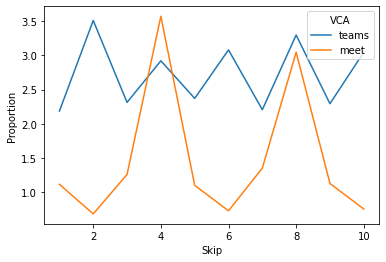

In [71]:
sns.lineplot(data=df_stat, x="Skip", y="Proportion", hue="VCA")
plt.xlabel("Skip")
plt.ylabel("Proportion")

In [72]:
print(data.keys())

dict_keys(['meet', 'teams'])


## Diagnostics 

In [78]:
%run "../scripts/diagnostic_functions.py"

In [195]:
def get_metric(fname, idx):
    arr = fname.split('-')
    return float(arr[idx+1])

def is_profile(x, prof):
    for metric in prof:
        if x[metric] != prof[metric]:
            return False
    return True

def get_min_max(x):
    return min(x), max(x)

def plot_metric(df_stat, metric, metric_prof, title=None, outfile=None, ylim=None):
    df_stat = df_stat[df_stat.apply(lambda x: is_profile(x, metric_prof), axis=1)]
    plt.figure()
    ax = sns.barplot(data=df_stat, x=metric, y="value", hue="variable", errorbar=get_min_max, estimator=np.median)
    #plt.title(title)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.tight_layout()
    plt.xlabel(metric_xlabels[metric])
    plt.ylabel("Normalized Value")
    handles, labels = ax.get_legend_handles_labels()
    lgd = plt.legend(handles=handles, labels=labels,
         loc="center right",   
         borderaxespad=0.1, 
         bbox_to_anchor = (1, 1.05),
         frameon=False,
         ncol=3,
         title_fontsize=8)
    if outfile:
        plt.savefig(outfile, bbox_extra_artists=(lgd,), bbox_inches='tight')


metric_list = ['tput', 'tput_std', 'lat', 'lat_std', 'loss', 'loss_std']

tput_prof = {'tput_std': 0, 'lat': 0, 'lat_std': 0, 'loss_std': 0, 'loss': 0}
tput_std_prof = {'tput': 5, 'lat': 0, 'lat_std': 0, 'loss_std': 0, 'loss': 0}
loss_prof = {'tput': 5, 'tput_std': 0, 'lat': 50, 'lat_std': 0, 'loss_std': 0}
loss_std_prof = {'tput': 5, 'tput_std':0, 'lat': 50, 'lat_std': 0, 'loss':2}
lat_prof = {'tput': 5, 'tput_std': 0, 'lat_std': 0, 'loss': 0, 'loss_std': 0}
lat_std_prof = {'tput': 5, 'tput_std':0, 'lat': 50, 'loss_std': 0, 'loss':0}
stat_cols = ["fname", "Interleaving", "Split", "Coalesce", "total_frames", "vca", "max_loopback"]
metric_prof_map = {"tput": tput_prof, "tput_std": tput_std_prof, "loss": loss_prof, "loss_std": loss_std_prof, "lat": lat_prof, "lat_std": lat_std_prof}
metric_xlabels = {"tput": "Throughput [Mbps]", "tput_std": "Throughput Std [Mbps]", "lat": "Latency [ms]", "lat_std": "Latency Std [ms]",
                 "loss": "Loss [%]", "loss_std": "Loss Std [%]"}


In [ ]:
max_lookbacks=[1,2]
stat_list = []
for max_lookback in max_lookbacks:
    print("max_lookback", max_lookback)
    for vca in vcas:
        print("processing ", vca)
        for fname in data[vca]:
            df_net = df_net_all[df_net_all["fname"] == fname]
            df_net = preprocess_trace(df_net = df_net, vca= vca)
            (count1, total_frames) = get_packet_reorders(df_rtp = df_net, max_lookback=max_lookback)
            count2 = exceed_intraframe_threshold(df_rtp = df_net)
            count3 = interframe_size_diff_within_intraframe(df_rtp = df_net, max_lookback=max_lookback)
            stat = [fname, count1, count2, count3, total_frames, vca, max_lookback]
            stat_list.append(stat)

In [179]:
df_stat = pd.DataFrame(stat_list, columns=stat_cols)

tput teams 1
tput_std teams 1
loss teams 1
loss_std teams 1
lat teams 1
lat_std teams 1
tput meet 1
tput_std meet 1
loss meet 1
loss_std meet 1
lat meet 1
lat_std meet 1
tput teams 2
tput_std teams 2
loss teams 2
loss_std teams 2
lat teams 2
lat_std teams 2
tput meet 2
tput_std meet 2
loss meet 2


/var/folders/m_/tn_v7vfs78d5fmk9d62sgrt80000gn/T/ipykernel_40706/3629528025.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


loss_std meet 2
lat meet 2
lat_std meet 2


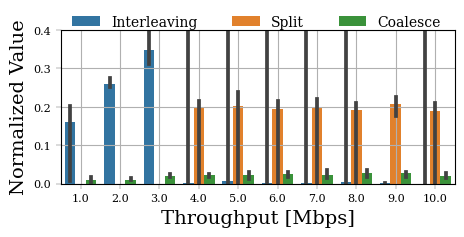

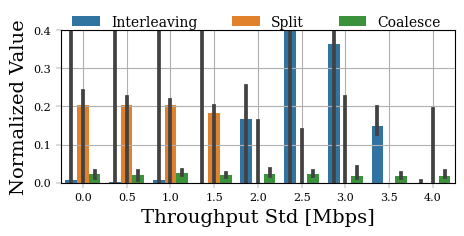

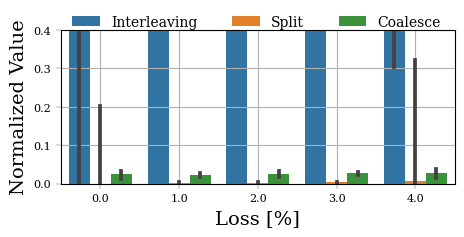

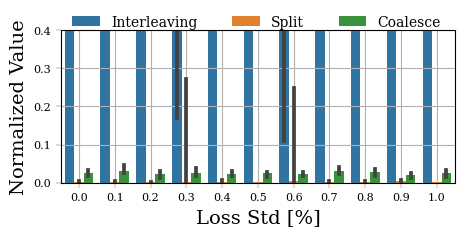

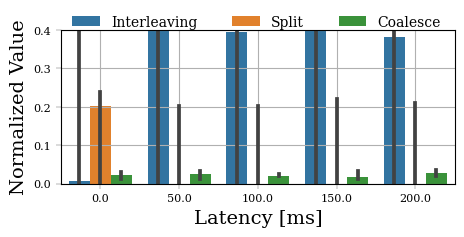

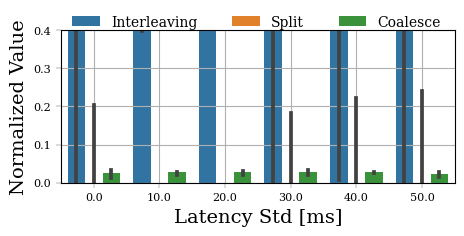

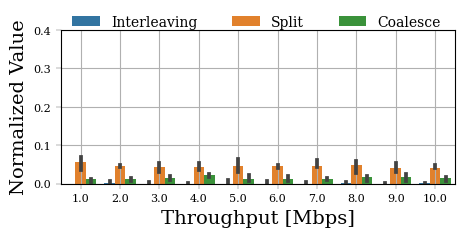

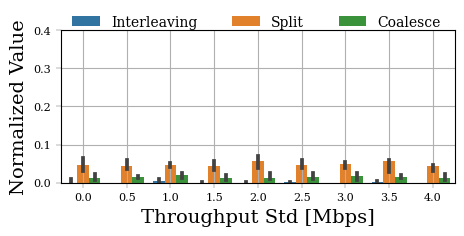

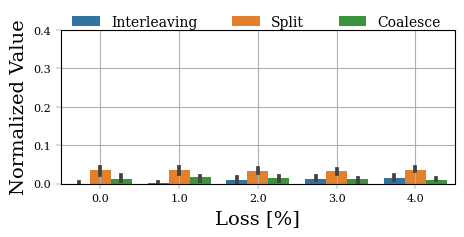

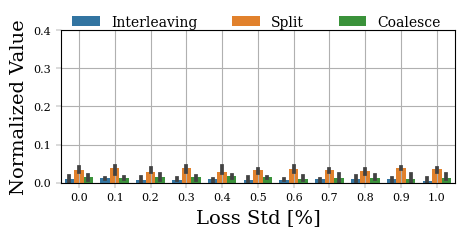

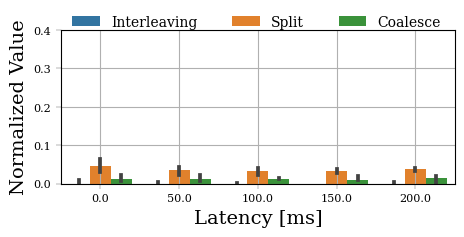

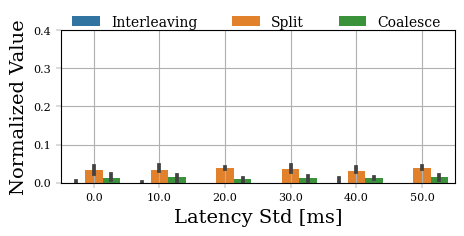

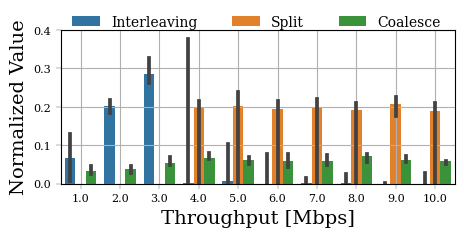

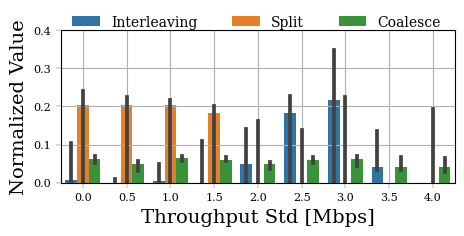

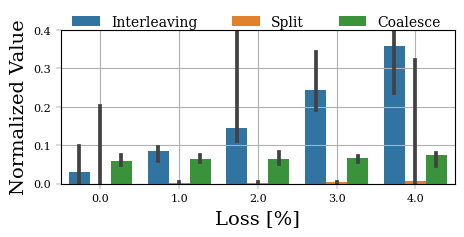

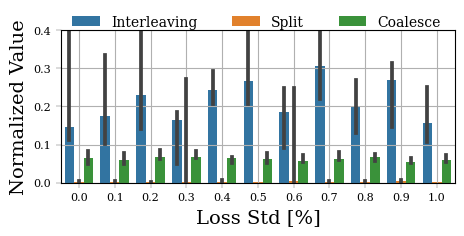

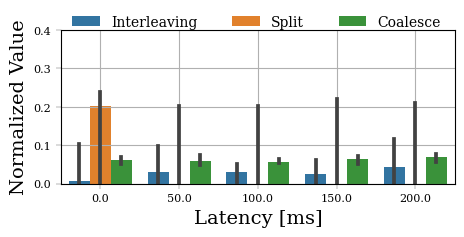

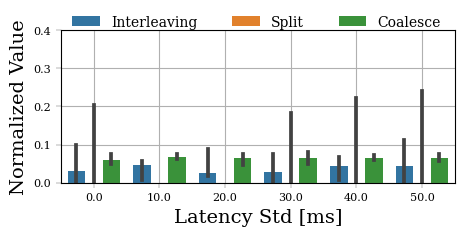

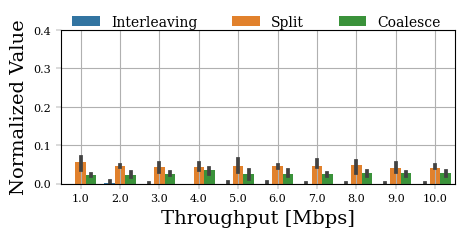

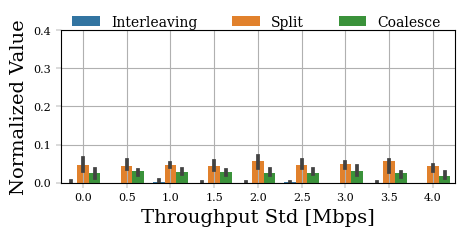

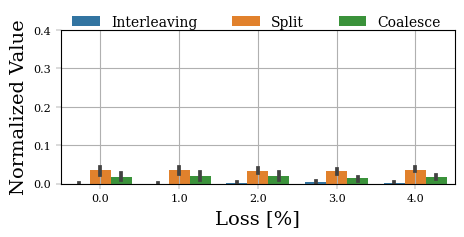

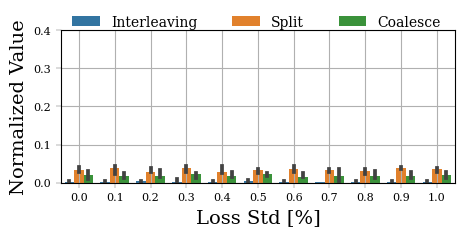

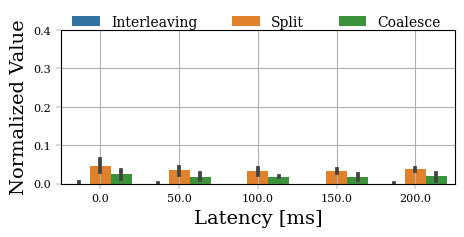

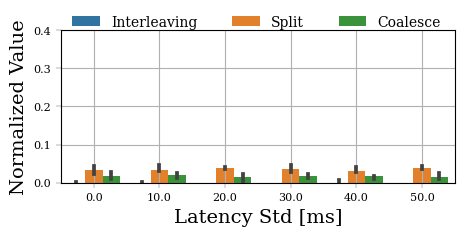

In [196]:
for max_lookback in [1, 2]:
    for vca in vcas:
        df_stat1 = df_stat[(df_stat["vca"] == vca) & (df_stat["max_loopback"] == max_lookback)]

        for i in range(0, len(metric_list)):
            metric = metric_list[i]
            df_stat1[metric] = df_stat1['fname'].apply(lambda x: get_metric(x, i))

        for col in stat_cols[1:4]:
            df_stat1[f"{col}_"] = df_stat1[col] / df_stat["total_frames"]


        df_stat2 = pd.melt(df_stat1, id_vars=metric_list, value_vars=[f"{x}_" for x in stat_cols[1:4]])

        for metric in metric_prof_map:
            print(metric, vca, max_lookback)
            outfile = f"plots/diagnosis_{vca}_{metric}_lookback_{max_lookback}.png"
            plot_metric(df_stat2, metric, metric_prof_map[metric], title=f"{vca} | {metric}", outfile=outfile, ylim=[0,0.4])
    

### Frame and Num packets

<AxesSubplot:xlabel='num_pkts', ylabel='frame_size'>

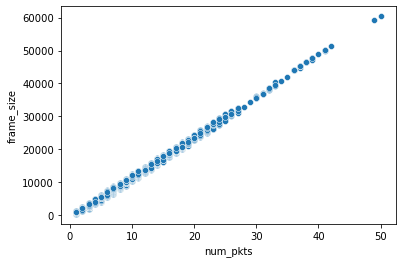

In [250]:
#df_frames.columns
#sns.ecdfplot(data=df_frames, x="num_pkts")
sns.ecdfplot(data=df_frames, x="frame_size")
#sns.scatterplot(data=df_frames, x="num_pkts", y="frame_size")

#### Debug

In [ ]:
def get_max_diff(x):
    diffs = [abs(x[i] - x[i-1]) for i in range(1, len(x))]
    try:
        return max(diffs)
    except:
        return -1
pd.options.display.max_rows = 700
vca = "teams"
fname =  "chrome-5-0-100-0-0-0-1667877526-1667877598.json"
df_net = df_net_all[df_net_all["fname"] == fname]
df_net = preprocess_trace(df_net = df_net, vca= vca)
df_net = df_net[(df_net["is_video_actual"] == 1) & (df_net["udp.length"] > video_size_thresh[vca])]
df_grp = df_net.groupby("rtp.timestamp").agg({"udp.length": list}).reset_index()
df_grp["max_diff"] = df_grp["udp.length"].apply(lambda x: get_max_diff(x))
df_grp["avg_size"] = df_grp["udp.length"].apply(np.mean)
for i in range(1, 4):
    df_grp[f"size_diff_{i}"] = df_grp["avg_size"].diff(periods=i)
    df_grp[f"size_diff_{i}"] = df_grp[f"size_diff_{i}"].apply(abs)
df_grp["min_diff"] = df_grp.apply(lambda x: min(x["size_diff_1"], x["size_diff_2"], x["size_diff_3"]), axis=1)
print(df_grp)
#print(df_grp[df_grp["min_diff"] <= size_diff_threshold[vca]].shape, df_grp.shape)
#sns.ecdfplot(df_grp["max_diff"])

## QoE inference

In [110]:
size_diff_thresh = {'meet': 4, 'teams': 2}

def get_frame_assignment_udp(df, vca, size_diff_thresh, windows=None, max_lookback=2):
    frame_id_assignment = []
    frame_id = 0
    avg_pkt_size = {}
    num_pkts = {}
    df['frame.time_relative'] = df['frame.time_relative'].astype(float)
    for i in range(0, df.shape[0]):
        curr_size = df.iloc[i]['udp.length']

        if curr_size <= video_size_thresh[vca]:
            frame_id_assignment.append(-1)
            continue
        
        found = False
        for lookback in range(max_lookback):
            prev_frame_id = frame_id-lookback
            if prev_frame_id <= 0:
                break
            if abs(avg_pkt_size[prev_frame_id]-curr_size) <= size_diff_thresh[vca]:
                found = True
                frame_id_assignment.append(prev_frame_id)
                n = num_pkts[prev_frame_id]
                avg_pkt_size[prev_frame_id] = (avg_pkt_size[prev_frame_id]*n + curr_size)/(n+1)
                num_pkts[prev_frame_id] += 1
                break
        if not found:
            frame_id += 1
            frame_id_assignment.append(frame_id)
            avg_pkt_size[frame_id] = curr_size
            num_pkts[frame_id] = 1
    df["frame.time_epoch"] = df["frame.time_epoch"].astype(float)
    df["frame_num"] = frame_id_assignment
    return df
    
def get_qoe_metrics(df, window=None):
    df['udp.length'] = df['udp.length'] - 12
    df_grp = df.groupby("frame_num").agg({"frame.time_epoch": list, "udp.length": list}).reset_index()
    df_grp["frame_st"] = df_grp["frame.time_epoch"].apply(lambda x: min(x))
    df_grp["frame_et"] = df_grp["frame.time_epoch"].apply(lambda x: max(x))
    df_grp["frame_size"] = df_grp["udp.length"].apply(lambda x: sum(x))
    
    if window:
        df_grp["ft_end"] = df_grp['frame_et'].apply(lambda x: get_window(x, window))
    else:
        df_grp["ft_end"] = df_grp['frame_et'].apply(lambda x: int(x))
    
    
    ## frame duration calculations
    df_grp["frame_dur"] = df_grp["frame_et"].diff()
    df_grp["avg_frame_dur"] = df_grp["frame_dur"].rolling(30).mean() # Why 30?
    df_grp = df_grp.fillna(0)
    
    ## freeze calculation
    #df_grp["is_freeze"] = df_grp.apply(is_freeze, axis=1)
    #df_grp["freeze_dur"] = df_grp.apply(get_freeze_dur, axis=1)
    
    
    
    df_grp = df_grp.groupby("ft_end").agg({"frame_size" : ["count", "sum"], 
                                           #"is_freeze": "sum", 
                                           #"freeze_dur": "sum", 
                                            "frame_dur": "std"}).reset_index()
    
    ## rename columns
    df_grp.columns = ['_'.join(col).strip('_') for col in df_grp.columns.values]    
    df_grp = df_grp.rename(columns={'frame_size_count': 'fps',
                                    'is_freeze_sum': 'freeze_count',
                                    'frame_size_sum': 'bitrate',
                                    'freeze_dur_sum': 'freeze_dur',
                                    'frame_dur_std': 'interframe_delay_std'
                                   })
    df_grp['bitrate'] = df_grp['bitrate']*8/1000 
    #print(df_grp['ft_end'].head(2))
    return df_grp

def get_frames_udp(df, vca, size_diff_thresh, window=None, max_lookback=2):
    df = get_frame_assignment_udp(df, vca, size_diff_thresh, max_lookback=max_lookback)
    df_grp = get_qoe_metrics(df, window)
    return df_grp


In [111]:
## RTP Frame 
def get_frame_assignment_rtp(df, vca, windows=None):
    df["rtp.p_type"] = df["rtp.p_type"].apply(lambda x: filter_ptype(x, vca))
    df["is_video_rtp"] = df["rtp.p_type"].apply(lambda x: is_video_rtp(x, vca))
    df = df[df["is_video_rtp"] == 1]
    df["frame_num"] = df["rtp.timestamp"]
    return df

def get_frames_rtp(df, vca, window=None):
    df = get_frame_assignment_rtp(df, vca)
    df_grp = get_qoe_metrics(df, window)
    return df_grp

In [112]:
data_frame_udp = {}
data_frame_rtp = {}

In [117]:
vcas = ["teams", "meet"]
max_lookbacks = [1, 2, 3]
for max_lookback in max_lookbacks:
    data_frame_udp[max_lookback] = {}
    for vca in vcas:
        print(vca)
        df_net = pd.concat([data[vca][x]['pcap'] for x in data[vca]]).reset_index()
        df_webrtc = pd.concat([data[vca][x]['webrtc'] for x in data[vca]]).reset_index()

        cols_to_print = ["fps", "framesPerSecond", "bitrate_x", "bitrate_y", "ts", "ft_end"]
        fname_list = df_net["fname"].unique().tolist()
        df_merge_list = []
        print("processing files")
        for fname in fname_list:
            df_net1 = df_net[df_net['fname'] == fname]
            df_webrtc1 = df_webrtc[df_webrtc['fname'] == fname]
            df_grp = get_frames_udp(df_net1, vca, size_diff_thresh, max_lookback=max_lookback)
            df_webrtc1['bitrate'] = df_webrtc1['[bytesReceived_in_bits/s]']  / 1000
            df_merge = pd.merge(df_grp, df_webrtc1, left_on="ft_end", right_on="ts", how="inner")
            #print(df_merge[cols_to_print], size_diff_thresh, vca)

            df_merge_list.append(df_merge)   
        print("finished processing")
        df_merge = pd.concat(df_merge_list).reset_index()
        df_merge["error_fps"] = df_merge["fps"] - df_merge["framesReceived"]
        data_frame_udp[max_lookback][vca] = df_merge

teams
processing files
finished processing
meet
processing files
finished processing


In [115]:
## RTP 
max_lookback = 1
vcas = ["teams", "meet"]
data_frame_rtp[max_lookback] = {}
for vca in vcas:
    print(vca)
    df_net = pd.concat([data[vca][x]['pcap'] for x in data[vca]]).reset_index()
    df_webrtc = pd.concat([data[vca][x]['webrtc'] for x in data[vca]]).reset_index()
    fname_list = df_net["fname"].unique().tolist()
    df_merge_list = []
    print("processing files")
    for fname in fname_list:
        df_net1 = df_net[df_net['fname'] == fname]
        
        df_webrtc1 = df_webrtc[df_webrtc['fname'] == fname]
        df_grp = get_frames_rtp(df_net1, vca)
        df_webrtc1['bitrate'] = df_webrtc1['[bytesReceived_in_bits/s]']  / 1000
        
        df_merge = pd.merge(df_grp, df_webrtc1, left_on="ft_end", right_on="ts", how="inner")
        #print(df_merge[cols_to_print], size_diff_thresh, vca)
        df_merge_list.append(df_merge)   
    print("finished processing")
    df_merge = pd.concat(df_merge_list).reset_index()
    df_merge["error_fps"] = df_merge["fps"] - df_merge["framesReceived"]
    data_frame_rtp[max_lookback][vca] = df_merge

teams
processing files
finished processing


In [175]:
from sklearn.metrics import mean_absolute_error as mae

def is_profile(x, prof):
    for metric in prof:
        if x[metric] != prof[metric]:
            return False
    return True

def get_mae(g, y_col1, y_col2):
    mae_val = mae(g[y_col1], g[y_col2])
    return mae_val

def plot_metric(df_merge1, metric, y = "error_fps", hue_col="method", y_col_map={"error_fps": "framesPerSecond"}, title=None, outfile=None, ylim=None, plot_type="box", ylabel="Error [FPS]"):
    plt.figure()
    if plot_type == "box":
        ax = sns.boxplot(data=df_merge1, x=metric, y=y, hue=hue_col, whis=[10,90], showfliers=False)
    elif plot_type == "line":
        ax = sns.lineplot(data=df_merge1, x=metric, y=y, hue=hue_col, marker='o')
    plt.ylim([-20, 20])
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.xlabel(metric_xlabels[metric])
    plt.ylabel(ylabel)
    handles, labels = ax.get_legend_handles_labels()
    lgd = plt.legend(handles=handles, labels=labels,
         loc="center right",   
         borderaxespad=0.01, 
         bbox_to_anchor = (1, 1.05),
         frameon=False,
         ncol=3,
         title_fontsize=8)
    if outfile:
        plt.savefig(outfile, bbox_extra_artists=(lgd,), bbox_inches='tight')



#### Diffferent Frame metrics

In [ ]:
def get_metric(fname, idx):
    arr = fname.split('-')
    return float(arr[idx+1])
metric_list = ['tput', 'tput_std', 'lat', 'lat_std', 'loss', 'loss_std']
vca = ['teams', 'meet']
for vca in vcas:
    for max_lookback in [1]:
        #for proto in ['rtp', 'udp']:
        df_merge_rtp = data_frame_rtp[max_lookback][vca]
        df_merge_rtp = df_merge_rtp.dropna(subset=["framesPerSecond", "framesReceived", "framesDecoded"])
        df_merge_rtp["error_fps"] = df_merge_rtp["fps"] - df_merge_rtp["framesPerSecond"]
        df_merge_rtp["error_framesReceived"] = df_merge_rtp["fps"] - df_merge_rtp["framesReceived"]
        df_merge_rtp["error_framesDecoded"] = df_merge_rtp["fps"] - df_merge_rtp["framesDecoded"]
        for i in range(0, len(metric_list)):
            metric = metric_list[i]
            df_merge_rtp[metric] = df_merge_rtp['fname'].apply(lambda x: get_metric(x, i))
            ## loss prof
        y_col_map = {
                        "error_fps": "framesPerSecond",
                        "error_framesReceived": "framesReceived",
                        "error_framesDecoded": "framesDecoded"
                    }
        '''
        plot_metric(df_merge_rtp, 'loss', loss_prof, y_cols=list(y_col_map.keys()), y_col_map=y_col_map)
        plot_metric_1(df_merge_rtp, 'loss', loss_prof, y_col="error_fps", y_col_map=y_col_map)
        plot_metric_1(df_merge_rtp, 'loss', loss_prof, y_col="error_framesReceived", y_col_map=y_col_map)
        plot_metric_1(df_merge_rtp, 'loss', loss_prof, y_col="error_framesDecoded", y_col_map=y_col_map)
        '''
        metric = 'tput'
        prof = tput_prof
        plot_metric(df_merge_rtp, metric, prof, y_cols=list(y_col_map.keys()), y_col_map=y_col_map)
        plot_metric_1(df_merge_rtp, metric, prof, y_col="error_fps", y_col_map=y_col_map)
        plot_metric_1(df_merge_rtp, metric, prof, y_col="error_framesReceived", y_col_map=y_col_map)
        plot_metric_1(df_merge_rtp, metric, prof, y_col="error_framesDecoded", y_col_map=y_col_map)

        tput_prof = {'tput_std': 0, 'lat': 0, 'lat_std': 0, 'loss_std': 0, 'loss': 0}
        tput_std_prof = {'tput': 5, 'lat': 0, 'lat_std': 0, 'loss_std': 0, 'loss': 0}
        loss_prof = {'tput': 5, 'tput_std': 0, 'lat': 50, 'lat_std': 0, 'loss_std': 0}
        loss_std_prof = {'tput': 5, 'tput_std':0, 'lat': 50, 'lat_std': 0, 'loss':2}
        lat_prof = {'tput': 5, 'tput_std': 0, 'lat_std': 0, 'loss': 0, 'loss_std': 0}
        lat_std_prof = {'tput': 5, 'tput_std':0, 'lat': 50, 'loss_std': 0, 'loss':0}
        
        
        '''
        ## loss_std_prof
        plot_metric(df_merge, 'loss_std', loss_std_prof)

        ## lat prof
        plot_metric(df_merge, 'lat', lat_prof)

        ## lat_std prof
        plot_metric(df_merge, 'lat_std', lat_std_prof)

        '''

#### RTP vs UDP

In [176]:
import matplotlib
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.5*3.125, 1.5*1.5],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2
                           })
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

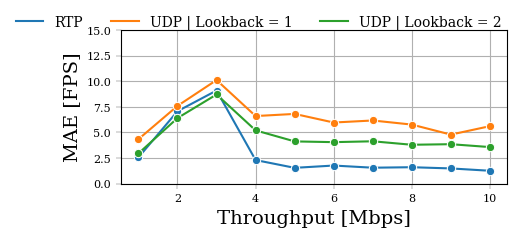

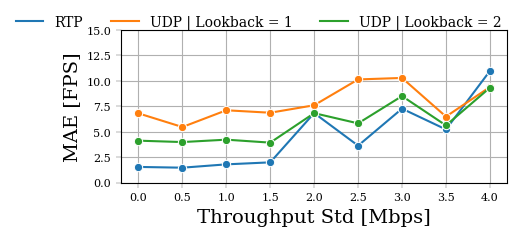

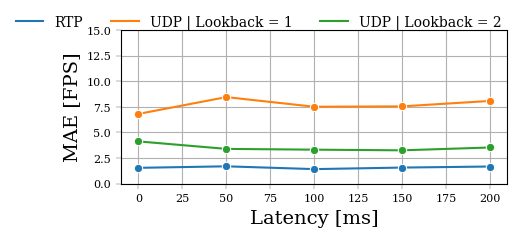

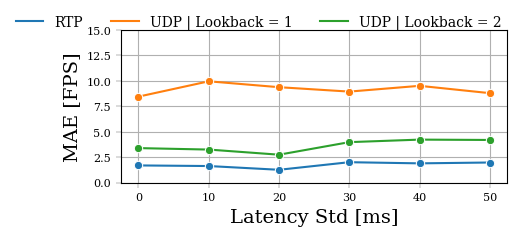

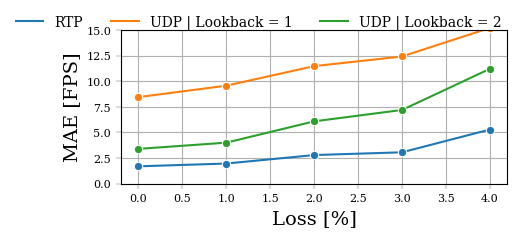

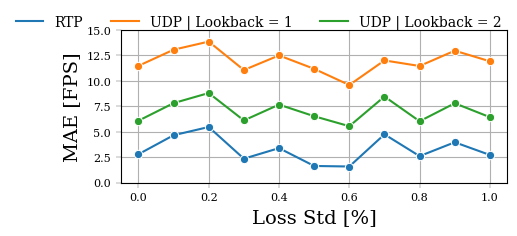

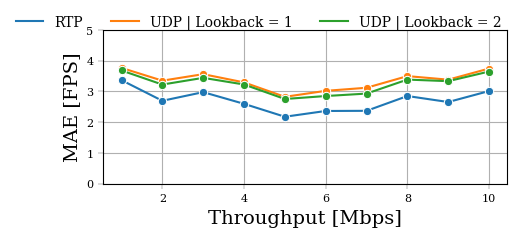

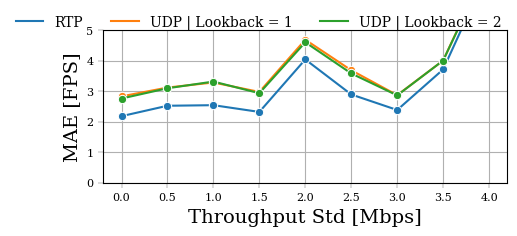

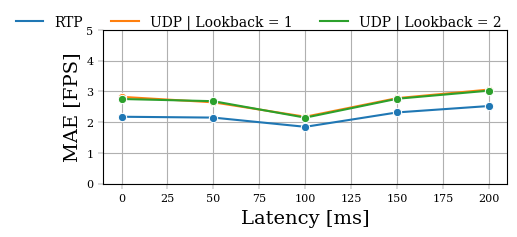

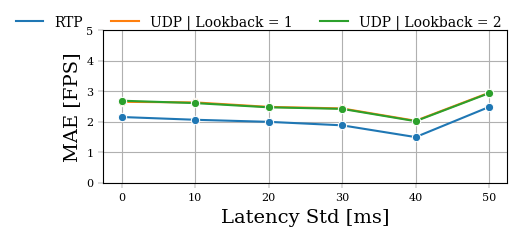

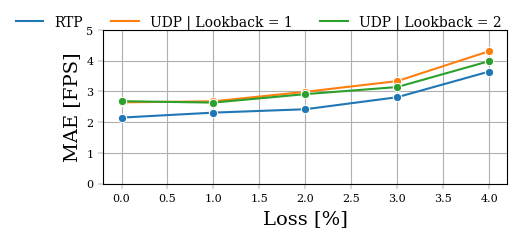

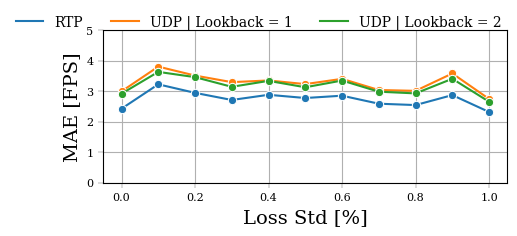

In [177]:
for vca in vcas:
    df_stat = []
    #for proto in ['rtp', 'udp']:
    df_merge_rtp = data_frame_rtp[1][vca]
    df_merge_rtp["error_fps"] = df_merge_rtp["fps"] - df_merge_rtp["framesPerSecond"]
    df_merge_rtp["method"] = "RTP"
    df_stat.append(df_merge_rtp)
    
    for max_lookback in [1, 2]:        
        df_merge_udp = data_frame_udp[max_lookback][vca]
        df_merge_udp["error_fps"] = df_merge_udp["fps"] - df_merge_udp["framesPerSecond"]
        df_merge_udp["method"] = f"UDP | Lookback = {max_lookback}"
        df_stat.append(df_merge_udp)
    
    df_stat_all = pd.concat(df_stat).reset_index(drop=True)
    for i in range(0, len(metric_list)):
        df_stat_all[metric_list[i]] = df_stat_all['fname'].apply(lambda x: get_metric(x, i))
    for metric in metric_list:       
        ylim_map = {"meet": (0,5), "teams": (0,15)}
        df_stat = df_stat_all[df_stat_all.apply(lambda x: is_profile(x, metric_prof_map[metric]), axis=1)] 
        df_grp = df_stat.groupby([metric, "method"]).apply(lambda x: get_mae(x, "fps", "framesPerSecond")).reset_index()
        #plt.figure()
        #sns.lineplot(data=df_grp, x=metric, y=0, hue="method")
        plot_metric(df_grp, metric, y=0, hue_col="method", plot_type="line", ylim=ylim_map[vca], outfile=f"plots/fps_mae_{vca}_{metric}.png", ylabel="MAE [FPS]")
        #sns.lineplot(data=df_stat, x=metric, y="error_fps", hue="method")
        #print(df_grp.sort_values(by=[metric, "method"]))
        #plot_metric(df_stat, metric, metric_prof_map[metric], y_col="error_fps", hue_col="method", outfile=f"fps_error_{vca}_{metric}.pdf", ylim=ylim_map[vca])


['1.7', '2.0', '2.8', '3.1', '5.3']
['8.5', '9.6', '11.5', '12.4', '15.2']
['3.4', '4.0', '6.1', '7.2', '11.2']
['2.5', '2.8', '3.8', '4.7', '8.9']
['2.2', '2.3', '2.4', '2.8', '3.6']
['2.6', '2.7', '3.0', '3.3', '4.3']
['2.7', '2.6', '2.9', '3.1', '4.0']
['2.9', '2.8', '2.9', '3.0', '3.9']


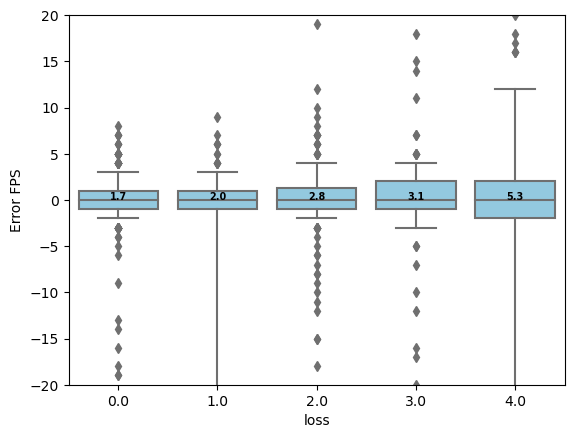

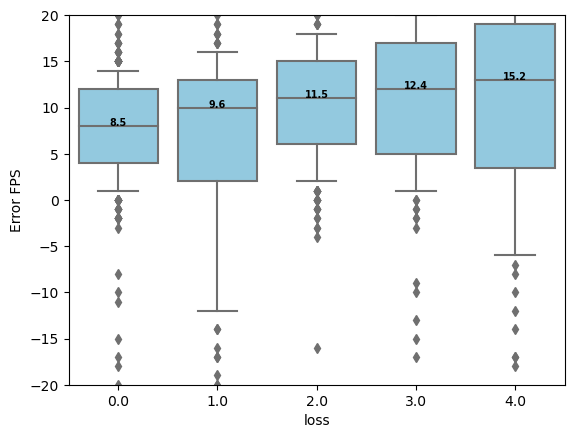

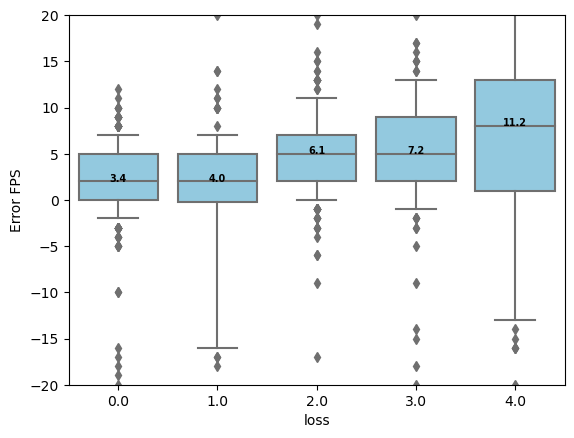

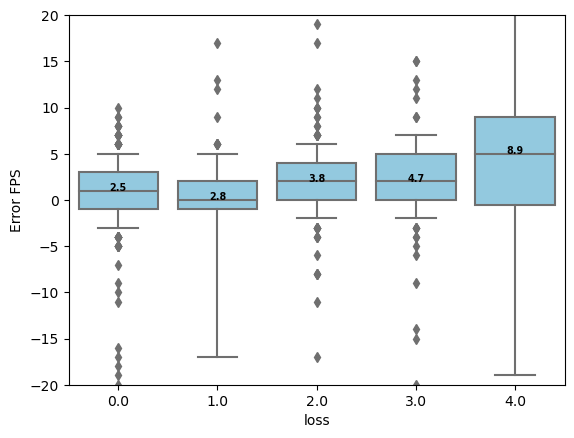

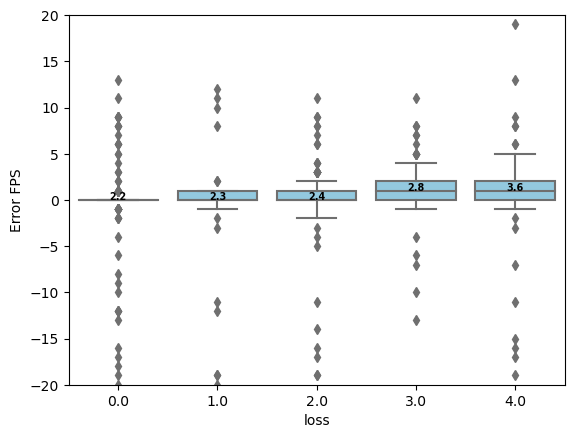

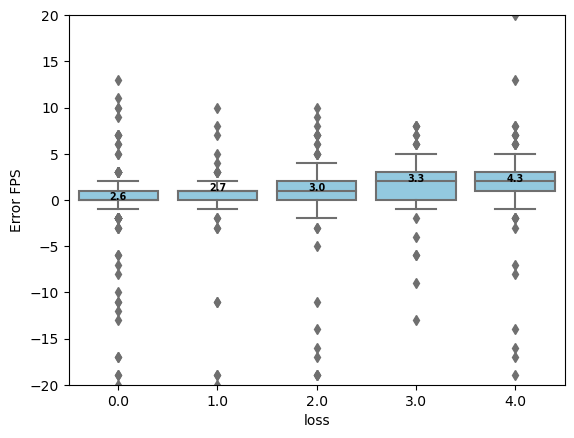

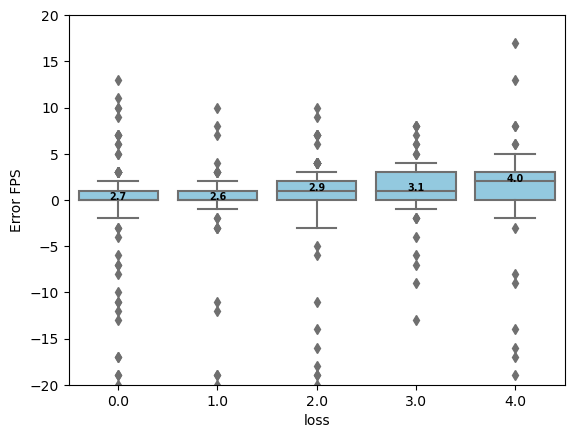

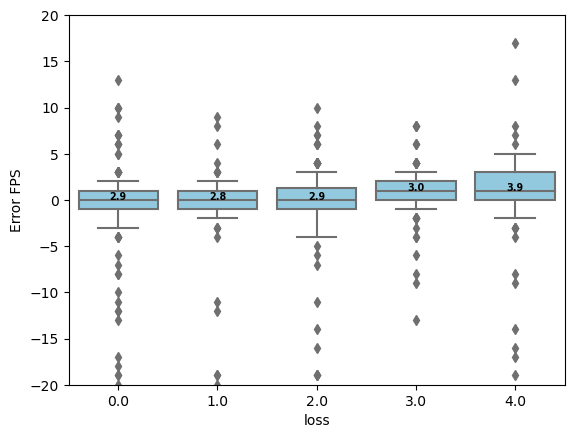

In [45]:
def get_metric(fname, idx):
    arr = fname.split('-')
    return float(arr[idx+1])
metric_list = ['tput', 'tput_std', 'lat', 'lat_std', 'loss', 'loss_std']
vca = ['teams', 'meet']
for vca in vcas:
    for max_lookback in [1, 2, 3]:
        #for proto in ['rtp', 'udp']:
        df_merge_udp = data_frame_udp[max_lookback][vca]
        df_merge_udp['proto'] = 
        pd.concat([df_merge_udp])
            if proto == 'udp':
                df_merge_udp = data_frame_udp[max_lookback][vca]
            elif proto == "rtp":
                if max_lookback not in data_frame_rtp:
                    continue
                df_merge_rtp = data_frame_rtp[max_lookback][vca]
            for i in range(0, len(metric_list)):

                metric = metric_list[i]
                df_merge[metric] = df_merge['fname'].apply(lambda x: get_metric(x, i))

#             ## Tput
#             tput_prof = {'tput_std': 0, 'lat': 0, 'lat_std': 0, 'loss_std': 0, 'loss': 0}
#             plot_metric(df_merge, 'tput', tput_prof)

#             ## Tput_std
#             tput_std_prof = {'tput': 5, 'lat': 0, 'lat_std': 0, 'loss_std': 0, 'loss': 0}
#             plot_metric(df_merge, 'tput_std', tput_std_prof)

            ## loss prof
            loss_prof = {'tput': 5, 'tput_std': 0, 'lat': 50, 'lat_std': 0, 'loss_std': 0}
            plot_metric(df_merge, 'loss', loss_prof)
            '''
            ## loss_std_prof
            loss_std_prof = {'tput': 5, 'tput_std':0, 'lat': 50, 'lat_std': 0, 'loss':2}
            plot_metric(df_merge, 'loss_std', loss_std_prof)

            ## lat prof
            lat_prof = {'tput': 5, 'tput_std': 0, 'lat_std': 0, 'loss': 0, 'loss_std': 0}
            plot_metric(df_merge, 'lat', lat_prof)

            ## lat_std prof
            lat_std_prof = {'tput': 5, 'tput_std':0, 'lat': 50, 'loss_std': 0, 'loss':0}
            plot_metric(df_merge, 'lat_std', lat_std_prof)

            '''

In [254]:
vca = "meet"
df_net = pd.concat([data[vca][x]['pcap'] for x in data[vca]]).reset_index()
df_net["is_video_rtp"] = df_net["rtp.p_type"].apply(lambda x: is_video_rtp(x, vca))
df_video = df_net[df_net["is_video_rtp"] == 1]
df_video = df_video[df_video["udp.length"] > 400]
df_frames = df_video.groupby("rtp.timestamp").agg({'udp.length': list}).reset_index()
df_frames['avg_size'] = df_frames['udp.length'].apply(np.mean)
df_frames['num_pkts'] = df_frames['udp.length'].apply(len)
df_frames['frame_size'] = df_frames['udp.length'].apply(sum)
df_frames["max_diff"] = df_frames["udp.length"].apply(lambda x: max(x) - min(x))

(0.0, 20.0)

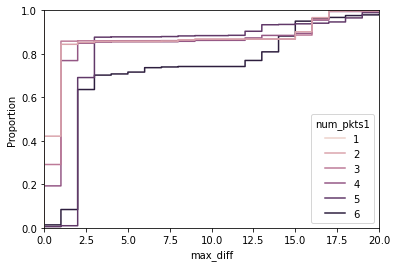

In [265]:
df_frames["num_pkts1"] = df_frames["num_pkts"].apply(lambda x: x if x < 6 else 6)
sns.ecdfplot(data=df_frames, x="max_diff", hue="num_pkts1")
plt.xlim([0,20])
#sns.scatterplot(data=df_frames, x="num_pkts", y="max_diff")

<AxesSubplot:xlabel='avg_size', ylabel='Proportion'>

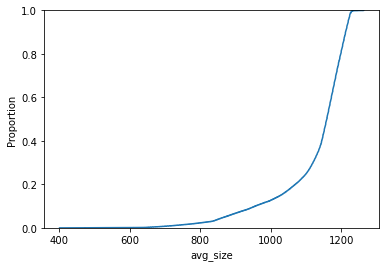

In [237]:
sns.ecdfplot(df_frames["avg_size"])

<AxesSubplot:xlabel='avg_size', ylabel='Proportion'>

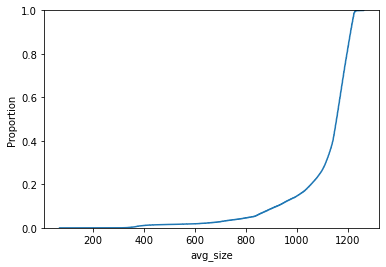

In [228]:
sns.ecdfplot(df_frames["avg_size"])

## Frame size and packet count analysis

In [201]:
vcas = ["teams", "meet"]
df_grp_map = {}

df_net_vca["is_video_rtp"] = df_net_vca["rtp.p_type"].apply(lambda x: is_video_rtp(x, vca))
        df_video = df_net_vca[(df_net_vca["is_video_rtp"] == 1) & (df_net_vca["udp.length"] > video_size_thresh[vca])] 
        df_grp = df_video.groupby(["fname", "rtp.timestamp"]).agg({"udp.length": list}).reset_index()
        df_grp["n_pkts"] = df_grp["udp.length"].apply(len)
        df_grp["size"] = df_grp["udp.length"].apply(sum)
    df_grp_map[vca] = df_grp


In [203]:
sns.ecdfplot(data = df_grp_map, x = "n_pkts", hue="vca")

KeyError: 'n_pkts'

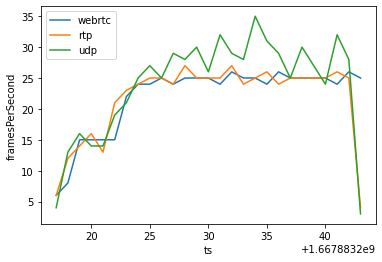

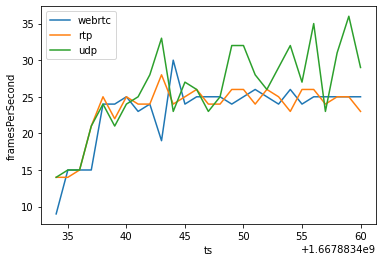

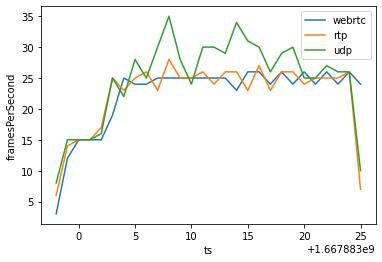

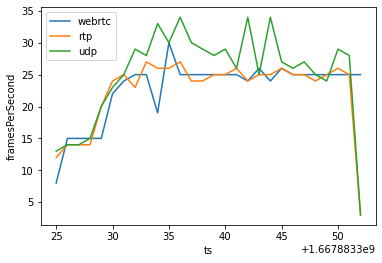

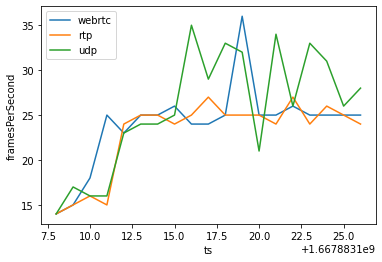

In [241]:
vca = "teams"
df_merge = data_frame_rtp[1][vca]
df_merge_udp = data_frame_udp[2][vca]
for i in range(0, len(metric_list)):
    metric = metric_list[i]
    df_merge[metric] = df_merge['fname'].apply(lambda x: get_metric(x, i))
    df_merge_udp[metric] = df_merge_udp['fname'].apply(lambda x: get_metric(x, i))
    
df_merge1 = df_merge[df_merge["loss"] == 1]
df_merge_udp_1 = df_merge_udp[df_merge_udp["loss"] == 1]
fname_list = df_merge1["fname"].unique().tolist()
for fname in fname_list:
    df_merge2 = df_merge1[df_merge1['fname']==fname]
    df_merge_udp_2 = df_merge_udp_1[df_merge_udp_1['fname']==fname]
    plt.figure()
    sns.lineplot(data=df_merge2, x="ts", y="framesPerSecond")
    sns.lineplot(data=df_merge2, x="ts", y="fps")
    sns.lineplot(data=df_merge_udp_2, x="ts", y="fps")
    plt.legend(['webrtc', 'rtp', 'udp'])

In [117]:
df_merge[df_merge["tput"] == 4][metric_list]

,tput,tput_std,lat,lat_std,loss,loss_std
2362,4.0,0.0,0.0,0.0,0.0,0.0
2363,4.0,0.0,0.0,0.0,0.0,0.0
2364,4.0,0.0,0.0,0.0,0.0,0.0
2365,4.0,0.0,0.0,0.0,0.0,0.0
2366,4.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
5210,4.0,0.0,0.0,0.0,0.0,0.0
5211,4.0,0.0,0.0,0.0,0.0,0.0
5212,4.0,0.0,0.0,0.0,0.0,0.0
5213,4.0,0.0,0.0,0.0,0.0,0.0


['3.4', '4.0', '6.1', '7.2', '11.2']
['3.0', '6.4', '8.7', '5.2', '4.1', '4.1', '4.1', '3.8', '3.9', '3.6']


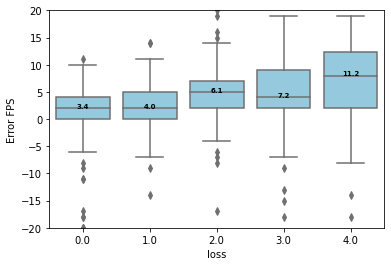

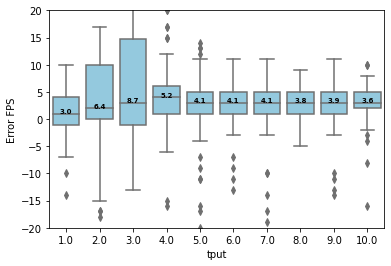

In [306]:
df_merge.shape

(785, 27)

<AxesSubplot:xlabel='ts', ylabel='fps'>

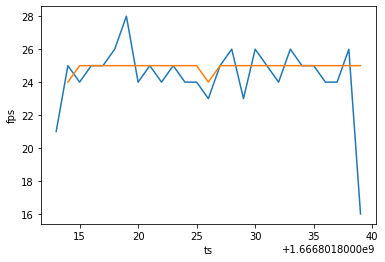

In [190]:
sns.ecdfplot(df_merge[""]

In [183]:
df_grp

,ft_end,fps,bitrate,interframe_delay_std
0,1666801813,21,320.984,0.021539
1,1666801814,25,270.320,0.008607
2,1666801815,24,271.080,0.030034
3,1666801816,25,318.672,0.016854
4,1666801817,25,319.648,0.019534
5,1666801818,26,329.656,0.029761
6,1666801819,28,378.824,0.023790
7,1666801820,24,305.976,0.031810
8,1666801821,25,290.728,0.011456
9,1666801822,24,318.496,0.030242
